In [2]:
from os.path import join,dirname,abspath
import numpy as np
import matplotlib.pyplot as plt
import asyncio
asyncio.get_event_loop()

<_UnixSelectorEventLoop running=True closed=False debug=False>

In [3]:
from lockstar_client.SinglePIDClient import SinglePIDClient
from lockstar_client.AWGClient import AWGClient
from lockstar_client.LinearizationClient import LinearizationClient
from lockstar_client.AWGPIDClient import AWGPIDClient

## Linearization Client

The code in the next cell is how any client is registered. 
After initialization, the client methods can be called by using
await client.client_method()

In [ ]:
lin_client = LinearizationClient('192.168.88.211', 10780, 1234)
if await lin_client.register_client_id():
     print(f'Successfully initialized Linearization module')


This module outputs a user-specified ramp, measures the static gain of the system
and calculates the linearization paramters. These are then stored in a file and can be used
by any other module.

The code below will plot the measurement and the inverted measurement after ~10s.

In [ ]:
ramp_start = 0.
ramp_end = 10.
ramp_length = 2000
settling_time_ms = 1

linearization_file = join(dirname(abspath('')), 'test_linearization.json')
# print(await lin_client.set_linearization_length_one(ramp_length))
# print(await lin_client.set_linearization_one_from_file(linearization_file))
# sys.exit()
ramp = np.linspace(ramp_start, ramp_end, num=ramp_length)

_ = await lin_client.set_ramp_parameters(ramp_start, ramp_end, ramp_length, settling_time_ms)
linearization_response = await lin_client.linearize_ch_one()

if linearization_response != False:
    measured_gain, linearization = linearization_response
    fig,ax = plt.subplots(1,1)
    ax.plot(ramp,measured_gain,label='measured gain')
    ax.plot(ramp,linearization,label='linearizaion')
    ax.legend()
    ax.grid('lightgray')
    plt.show()

    _ = await lin_client.store_linearization_locally(linearization, ramp_start, ramp_end, linearization_file)

    _ = await lin_client.set_linearization_length_one(ramp_length)
    #_ = await lin_client.set_linearization_one(linearization, min_output_voltage=ramp_start, max_output_voltage=ramp_end)
    _ = await lin_client.set_linearization_one_from_file(linearization_file)

    

## Single PID Client

In [8]:
#connect to client
pid_client = SinglePIDClient('192.168.88.211', 10780, 1234)
await pid_client.initialize(1,2,3,4,5, True, 0, 1)
if await pid_client.register_client_id():
     print(f'Successfully initialized single PID module')

Successfully initialized single PID module


In [9]:
await pid_client.set_output_limits(min=0, max=10)

ACK

In [16]:
await pid_client.set_pid(p=0.1, i=100, d=0, input_offset=0, output_offset=0)

ACK

In [12]:
await pid_client.lock()

ACK

In [ ]:
await pid_client.unlock()

# AWG Client

In [17]:
awg_client = AWGClient('192.168.88.211', 10780, 1234)
await awg_client.initialize()
if await awg_client.register_client_id():
    print(f'Successfully initialized AWG module')

Successfully initialized AWG module


ch_x_chunks (x=one,two) holds the lengths of the concatenated waveforms.
The next chunk of both channels is triggered by calling output_on().
output_off() resets the pointer to the first chunk.

Max. number of chunks (sum of both channels) is 100.
In total you can have 40000 samples.

ch_x_buffer holds the waveforms.
If linearization is desired, use the next cell containing
set_linearization_length_x and set_linearization_x_from_file.

(There are two known bugs:
After the first time setting the linearization it returns a NACK.
Just execute the cell again, it should work.
Also after a few times setting the channel buffers, is also returns NACKs.
Please call the cell containing flash_mc to reset the microcontroller)

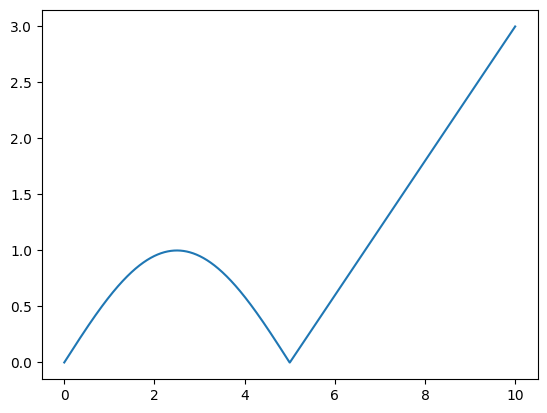

ACK
ACK
ACK
ACK
ACK
ACK
ACK


In [31]:
linearization_file = join(dirname(abspath('')), 'test_linearization.json')
linearization_length = 2000

sampling_rate = 1000

ch_one_chunks = [1999]
ch_one_buffer = np.sin(np.pi*np.linspace(0,1,1000))
ch_one_buffer = np.concatenate([ch_one_buffer,np.linspace(0,3,1000)])
plt.plot(np.linspace(0,10,2000),ch_one_buffer)
plt.show()
ch_one_buffer = ch_one_buffer.tolist()
ch_two_chunks = [0]
ch_two_buffer = [0.]
print(await awg_client.initialize_buffers(len(ch_one_buffer), 1, len(ch_one_chunks), 1, sampling_rate))
print(await awg_client.set_ch_one_output_limits(0, 10))
print(await awg_client.set_ch_two_output_limits(0, 10))
print(await awg_client.set_ch_one_chunks(ch_one_chunks))
print(await awg_client.set_ch_two_chunks(ch_two_chunks))
print(await awg_client.set_ch_one_buffer(ch_one_buffer))
print(await awg_client.set_ch_two_buffer(ch_two_buffer))


In [32]:
print(await awg_client.set_linearization_length_one(linearization_length))
print("set inverted pivot points:")
print(await awg_client.set_linearization_one_from_file(linearization_file))

ACK
set inverted pivot points:
ACK


In [21]:
await awg_client.output_on()

ACK

Use this to reset the module:

In [30]:
await awg_client.flash_mc()

ACK

# Matrix Client

The following code is intended to be used in conjunction with the Matrix. The Matrix is currently programmed to send samples to the lockstar before every run, which are then used as setpoint for PID loops running on the Lockstar. These samples (or chunks as they are called internally) are triggered via the TTL input of the Lockstar.

The following notebook is intended to be used for the following tasks:

- Finding and setting (for now) PID parameters
- Checking if the right setpoints have been sent to the Lockstar by the Matrix (for debugging)

In [4]:
#initializing the client
awg_pid_client = AWGPIDClient('192.168.88.25', 10780, 10780) #client-id: 10780 is the one the Matrix uses --> like that the python client can overwrite stuff set by the Matrix and vice versa

## Linearization

In [ ]:
linearization_file_one = join(dirname(abspath('')), 'awg_pid_lin_one.json')
linearization_file_two = join(dirname(abspath('')), 'awg_pid_lin_two.json')

In [ ]:
#Do linearization!!!

In [ ]:
awg_pid_client.set_linearization_one_from_file()
awg_pid_client.set_linearization_two_from_file()

## Setting PID

In [4]:
await awg_pid_client.set_pid_one(p=1, i=1000, d=0, input_offset=0., output_offset=0., i_threshold=0.001)
await awg_pid_client.enable_intensity_lock_mode_one()

ACK

In [6]:
await awg_pid_client.set_pid_two(p=1, i=1000, d=0, input_offset=0., output_offset=0., i_threshold=0.001)
await awg_pid_client.enable_intensity_lock_mode_two()

ACK

## Getting the setpoints

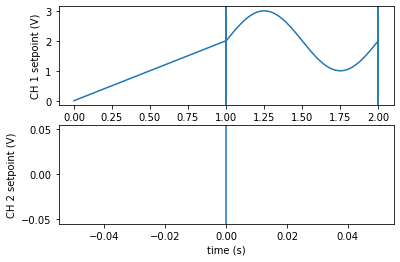

In [5]:
ch_one_chunks = np.array(await awg_pid_client.get_ch_one_chunks())
ch_two_chunks = np.array(await awg_pid_client.get_ch_two_chunks())
ch_one_buffer = np.array(await awg_pid_client.get_ch_one_buffer())
ch_two_buffer = np.array(await awg_pid_client.get_ch_two_buffer())

sampling_rate = await awg_pid_client.get_sampling_rate()

n_samples_one = ch_one_buffer.size
n_samples_two = ch_two_buffer.size

t_axis_one = np.linspace(0, n_samples_one/sampling_rate, num=n_samples_one)
t_axis_two = np.linspace(0, n_samples_two/sampling_rate, num=n_samples_two)

fig, (ax_one, ax_two) = plt.subplots(nrows=2)

ax_one.plot(t_axis_one, ch_one_buffer)
ax_two.plot(t_axis_two, ch_two_buffer)

#displaying chunks
for chunk in ch_one_chunks:
    ax_one.axvline(x=t_axis_one[chunk])

for chunk in ch_two_chunks:
    ax_two.axvline(x=t_axis_two[chunk])

ax_one.set_xlabel('time (s)')
ax_two.set_xlabel('time (s)')
ax_one.set_ylabel('CH 1 setpoint (V)')
ax_two.set_ylabel('CH 2 setpoint (V)')


plt.show()

In [9]:
await awg_pid_client.flash_mc()

NACK